# Code for generating sample paths of alternative models and plotting results
This notebook will first generate sample paths according to the model descriptions in Ben-Yami et al. 2023. This part does not need to be run, as there are already sample paths available to download. Runtime for 1000 sample paths for all models is about 30mins.

After generating the sample paths, the R script `AMOCestimation_altModels.Rmd` needs to be run. The files containing results of $t_c$ and the normal residuals are automatically saved in the same folder.

From these results, the histograms and QQ-plots are generated.


In [200]:
import time
import os
import scipy
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.graphics.gofplots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcdefaults() 
#from jupyterthemes import jtplot
#jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')

plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.rcParams.update({'font.family': 'serif',
                     'text.usetex': True,
                     'font.serif': ['Helvetica'],
                     'font.size': 2*8,
                     'axes.labelsize': 2*8,
                     'axes.titlesize': 2*12,
                     'figure.titlesize': 2*14})


# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.sans-serif'] = ['Arial']
# hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

### Generate sample paths of different models

In [201]:
t_start = 1870+1/12 #Time series start
t_end = 2021 #Time series end

tspan = np.linspace(t_start,t_end,round((t_end-t_start)*12+1),endpoint=True) #Time array of samples
integration_permonth = 20 #Discretisation of integration. Same as in Ditlevsen 2023
integration_timestep = 1/(12*integration_permonth) #Corresponding time step
integration_tspan = np.linspace(t_start,t_end,round((t_end-t_start)*12*integration_permonth+1),endpoint=True) #Time array for integration

# Values for parameters are taken from the tipping time estimation in Ditlevsen 2023
t_0 = 1924
#tau_r = 132.52
lambda_0 = -2.69
A_ = 0.87
m_ = -1.51
sigma_ = 0.3**0.5

# Set tipping times/ramping lengths convenient for demonstration purposes
tau_rs = {"fnf_wn_linforc":201,
          "fnf_rn_linforc":226,
          "ou_wn_linforc":132.52,
          "ou_rn_linforc":201,
          "sc_wn_linforc":201,
          "fnf_wn_slowforc":150,
          "fnf_wn_accforc":106}

Model 1: Fold normal form

In [202]:

# Linear ramp of control parameter
def lambda_1a(t):
    return lambda_0*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["fnf_wn_linforc"])

# Fold normal form model
def f_1a(x,t):
    return -A_*(x-m_)**2-lambda_1a(t)


# Linear ramp of control parameter
def lambda_1b(t):
    return lambda_0*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["fnf_rn_linforc"])

# Fold normal form model
def f_1b(x,t):
    return -A_*(x-m_)**2-lambda_1b(t)


Model 2: Ornstein-Uhlenbeck with time dependent mean

In [203]:
# Mean evolves linearly towards the value of the bifurcation point of the above fold normal form model
def mu_2a(t):
    return (m_+(abs(lambda_0/A_)**0.5))*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["ou_wn_linforc"]) + m_*np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["ou_wn_linforc"]

# OU model. No tipping possible
def f_2a(x,t):
    return -2*(A_*abs(lambda_0))**0.5*(x-mu_2a(t))


# Mean evolves linearly towards the value of the bifurcation point of the above fold normal form model
def mu_2b(t):
    return (m_+(abs(lambda_0/A_)**0.5))*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["ou_rn_linforc"]) + m_*np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["ou_rn_linforc"]

# OU model. No tipping possible
def f_2b(x,t):
    return -2*(A_*abs(lambda_0))**0.5*(x-mu_2b(t))

Model 3: Stommel-Cessi model

In [204]:
# Model parameters are taken from Lux et al. 2022
eta2 = 7.5
lambda_sc_0 = 0
lambda_sc_c = 2/3 + 2*eta2/27 + (1/9-1/(3*eta2))**0.5*(2*eta2/9-2/3)
vertical_scaling = (2/3 - (1/9-1/(3*eta2))**0.5)/(abs(lambda_0)/A_)**0.5 # scaling is introduced to have a similar absolute AMOC ramp to model 1

# Linear ramp of control parameter
def lambda_sc(t):
    return lambda_sc_0*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["sc_wn_linforc"]) + lambda_sc_c*np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["sc_wn_linforc"]

#Stommel-Cessi model
def f_3(x,t):
    return -(1 + eta2*((vertical_scaling*x)-1)**2)*(vertical_scaling*x)+lambda_sc(t)


Model 4: Slowing or accelerating ramps

In [205]:
# Linear ramp of control parameter, but with faster initial slope (later part is omitted)
def lambda_slow(t):
    return lambda_0*(1-np.heaviside(t-t_0,0))+np.heaviside(t-t_0,0)*lambda_0*abs(1-1.2*(t-t_0)/tau_rs["fnf_wn_slowforc"])**1

# Linear ramp of control parameter, but with slower initial slope (later part is omitted)
def lambda_acc(t):
    return lambda_0*(1-np.heaviside(t-t_0,0))+np.heaviside(t-t_0,0)*lambda_0*abs(1-0.8*(t-t_0)/tau_rs["fnf_wn_accforc"])**1

# Fold normal form models with new control parameter ramps
def f_4a(x,t):
    return -A_*(x-m_)**2-lambda_slow(t)
def f_4b(x,t):
    return -A_*(x-m_)**2-lambda_acc(t)


Integrate each of the models using the Euler(-Maruyama) method and save the paths to csv files
### Only run if you would like to make changes to the models. Data is available. Activate the respective models through the boolean variable.

In [206]:
np.random.seed(0)

samplesize = 1000
sampless = []

os.makedirs("SamplePathData/",exist_ok=True)

run_fnf_wn_linforc  = 1
run_fnf_rn_linforc  = 1
run_ou_wn_linforc   = 1
run_ou_rn_linforc   = 1
run_sc_wn_linforc   = 1
run_fnf_wn_slowforc = 1
run_fnf_wn_accforc  = 1

samples_1a = np.empty((samplesize,len(integration_tspan),))
samples_1a.fill(np.nan)
samples_1b = np.empty((samplesize,len(integration_tspan),))
samples_1b.fill(np.nan)
samples_2a = np.empty((samplesize,len(integration_tspan),))
samples_2a.fill(np.nan)
samples_2b = np.empty((samplesize,len(integration_tspan),))
samples_2b.fill(np.nan)
samples_3 = np.empty((samplesize,len(integration_tspan),))
samples_3.fill(np.nan)
samples_4a = np.empty((samplesize,len(integration_tspan),))
samples_4a.fill(np.nan)
samples_4b = np.empty((samplesize,len(integration_tspan),))
samples_4b.fill(np.nan)


for k in range(samplesize):
    print(k)
    if run_fnf_wn_linforc:
        white_noise_instance = np.random.normal(0,sigma_,len(integration_tspan)-1)
        samples_1a[k,0] = m_+(abs(lambda_0)/A_)**0.5
        for i in range(len(integration_tspan)-1):
            samples_1a[k,i+1] = samples_1a[k,i] + (f_1a(samples_1a[k,i],integration_tspan[i]))*integration_timestep + white_noise_instance[i]*integration_timestep**0.5
            if samples_1a[k,i]<-2:
                print("tip1a")
                break
                


    if run_fnf_rn_linforc:
        theta_0 = 20
        theta_c = 17
        thetas = np.array([theta_0*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["fnf_rn_linforc"]) + theta_c*np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["fnf_rn_linforc"] for t in integration_tspan])
        ar1_coeffs = np.exp(-thetas*integration_timestep)
        kappa = sigma_*(2*thetas[0])**0.5*18
        red_noise_instance = [np.random.normal(0,kappa/(2*theta_0)**0.5)]
        for i in range(len(integration_tspan)-1):
            red_noise_instance.append(ar1_coeffs[i]*red_noise_instance[-1] + np.sqrt(kappa / (2 * thetas[i]) * (1 - np.exp(-2 * thetas[i] * integration_timestep))) * np.random.normal(0, 1))
        red_noise_instance = np.array(red_noise_instance)

        samples_1b[k,0] = m_+(abs(lambda_0)/A_)**0.5
        for i in range(len(integration_tspan)-1):
            samples_1b[k,i+1] = samples_1b[k,i] + (f_1b(samples_1b[k,i],integration_tspan[i]))*integration_timestep + red_noise_instance[i]*integration_timestep
            if samples_1b[k,i]<-2:
                print("tip1b")
                break

    if run_ou_wn_linforc:
        white_noise_instance = np.random.normal(0,sigma_,len(integration_tspan)-1)
        samples_2a[k,0] = mu_2a(t_start)
        for i in range(len(integration_tspan)-1):
            samples_2a[k,i+1] = samples_2a[k,i] + f_2a(samples_2a[k,i],integration_tspan[i])*integration_timestep + white_noise_instance[i]*integration_timestep**0.5

    if run_ou_rn_linforc:
        theta_0 = 20
        theta_c = 8
        thetas = np.array([theta_0*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["ou_rn_linforc"]) + theta_c*np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["ou_rn_linforc"] for t in integration_tspan])
        ar1_coeffs = np.exp(-thetas*integration_timestep)
        kappa = sigma_*(2*thetas[0])**0.5*18
        red_noise_instance = [np.random.normal(0,kappa/(2*theta_0)**0.5)]
        for i in range(len(integration_tspan)-1):
            red_noise_instance.append(ar1_coeffs[i]*red_noise_instance[-1] + np.sqrt(kappa / (2 * thetas[i]) * (1 - np.exp(-2 * thetas[i] * integration_timestep))) * np.random.normal(0, 1))
        red_noise_instance = np.array(red_noise_instance)

        samples_2b[k,0] = mu_2b(t_start)
        for i in range(len(integration_tspan)-1):
            samples_2b[k,i+1] = samples_2b[k,i] + f_2b(samples_2b[k,i],integration_tspan[i])*integration_timestep + red_noise_instance[i]*integration_timestep

    if run_sc_wn_linforc:
        white_noise_instance = np.random.normal(0,sigma_,len(integration_tspan)-1)
        sc_noise_scaling = 0.8
        samples_3[k,0] = m_+(abs(lambda_0)/A_)**0.5
        for i in range(len(integration_tspan)-1):
            samples_3[k,i+1] = samples_3[k,i] + f_3(samples_3[k,i],integration_tspan[i])*integration_timestep + sc_noise_scaling*white_noise_instance[i]*integration_timestep**0.5
            if samples_3[k,i]<-2:
                print("tip3")
                break
        samples_3[k,:] = -1*(samples_3[k,:] - (m_+(abs(lambda_0)/A_)**0.5))

    if run_fnf_wn_slowforc:  
        white_noise_instance = np.random.normal(0,sigma_,len(integration_tspan)-1)
        samples_4a[k,0] = m_+(abs(lambda_0)/A_)**0.5
        for i in range(len(integration_tspan)-1):
            samples_4a[k,i+1] = samples_4a[k,i] + (f_4a(samples_4a[k,i],integration_tspan[i]))*integration_timestep + white_noise_instance[i]*integration_timestep**0.5
            if samples_4a[k,i]<-2:
                print("tip4a")
                break

    if run_fnf_wn_accforc:
        white_noise_instance = np.random.normal(0,sigma_,len(integration_tspan)-1)
        samples_4b[k,0] = m_+(abs(lambda_0)/A_)**0.5
        for i in range(len(integration_tspan)-1):
            samples_4b[k,i+1] = samples_4b[k,i] + (f_4b(samples_4b[k,i],integration_tspan[i]))*integration_timestep + white_noise_instance[i]*integration_timestep**0.5
            if samples_4b[k,i]<-2:
                print("tip4b")
                break

if run_fnf_wn_linforc:
    samples_1a = samples_1a[:,::integration_permonth]
    pd.DataFrame(np.array(samples_1a).transpose()).to_csv("SamplePathData/fnf_wn_linforc.csv")
if run_fnf_rn_linforc:
    samples_1b = samples_1b[:,::integration_permonth]
    pd.DataFrame(np.array(samples_1b).transpose()).to_csv("SamplePathData/fnf_rn_linforc.csv")
if run_ou_wn_linforc:
    samples_2a = samples_2a[:,::integration_permonth]
    pd.DataFrame(np.array(samples_2a).transpose()).to_csv("SamplePathData/ou_wn_linforc.csv")
if run_ou_rn_linforc:
    samples_2b = samples_2b[:,::integration_permonth]
    pd.DataFrame(np.array(samples_2b).transpose()).to_csv("SamplePathData/ou_rn_linforc.csv")
if run_sc_wn_linforc:
    samples_3 = samples_3[:,::integration_permonth]
    pd.DataFrame(np.array(samples_3).transpose()).to_csv("SamplePathData/sc_wn_linforc.csv")
if run_fnf_wn_slowforc:
    samples_4a = samples_4a[:,::integration_permonth]
    pd.DataFrame(np.array(samples_4a).transpose()).to_csv("SamplePathData/fnf_wn_slowforc.csv")
if run_fnf_wn_accforc:
    samples_4b = samples_4b[:,::integration_permonth]
    pd.DataFrame(np.array(samples_4b).transpose()).to_csv("SamplePathData/fnf_wn_accforc.csv")

0
1
2
tip4a
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
tip4b
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
tip4b
50
51
52
53
54
55
56
57
tip4a
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
tip4a
82
83
84
85
86
87
88
89
90
tip4a
91
92
93
tip4a
94
95
96
97
98
99
100
101
102
tip4a
103
104
105
106
107
108
109
tip4a
110
111
112
113
114
115
116
117
118
tip4a
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
tip4b
136
137
138
139
140
141
tip4a
142
143
144
145
146
147
148
149
tip4b
150
151
152
153
tip4a
154
155
156
157
158
159
160
161
162
163
164
165
166
167
tip4b
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
tip4b
196
197
198
199
200
201
202
203
204
205
206
207
208
209
tip4a
210
211
tip4a
212
213
214
215
tip4a
216
217
218
219
220
221
222
223
224
225
226
227
228
229
tip4a
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
24

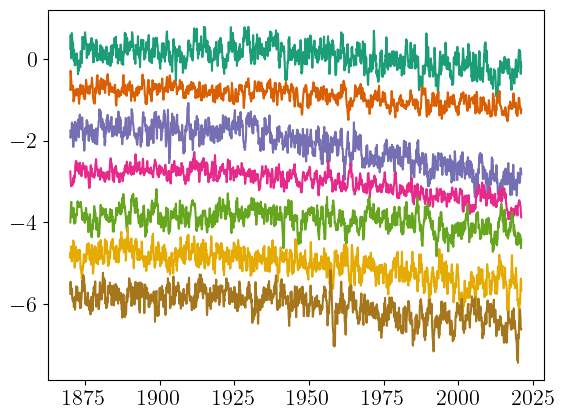

In [207]:
plt.plot(tspan,samples_1a[0,:])
plt.plot(tspan,samples_1b[0,:]-1)
plt.plot(tspan,samples_2a[0,:]-2)
plt.plot(tspan,samples_2b[0,:]-3)
plt.plot(tspan,samples_3[0,:]-4)
plt.plot(tspan,samples_4a[0,:]-5)
plt.plot(tspan,samples_4b[0,:]-6)
plt.show()

### Plot results obtained from the R script

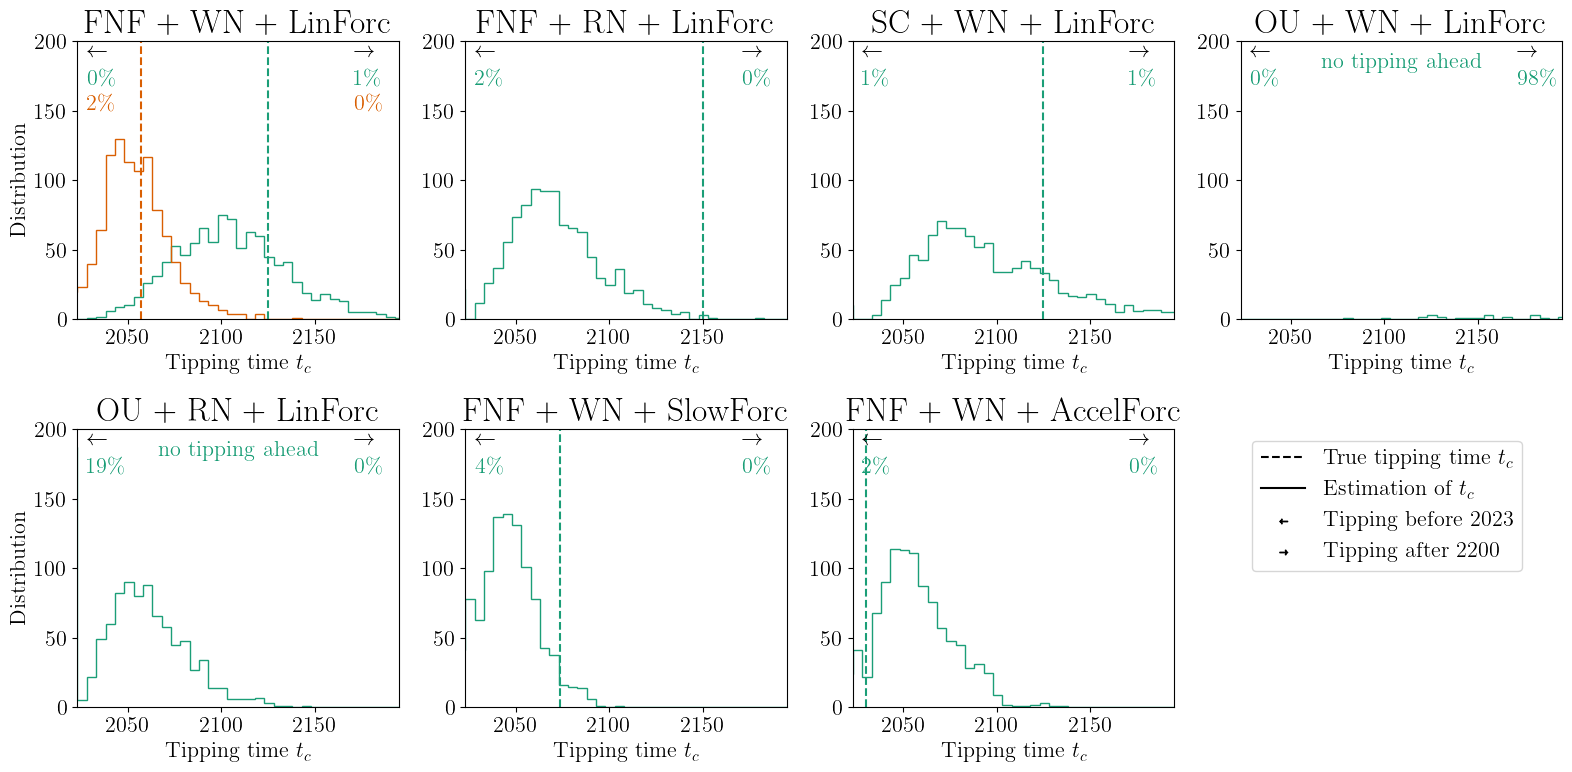

In [218]:
modelnames= ["fnf_wn_linforc","fnf_rn_linforc","sc_wn_linforc","ou_wn_linforc","ou_rn_linforc","fnf_wn_slowforc","fnf_wn_accforc"]
t_left = 2023
t_right = 2200
t_step = 5
modeldescrips = ["FNF + WN + LinForc","FNF + RN + LinForc","SC + WN + LinForc","OU + WN + LinForc","OU + RN + LinForc","FNF + WN + SlowForc","FNF + WN + AccelForc"]
fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(16,8),tight_layout=True)
axs=axs.flatten()
bins = np.concatenate((np.array([0]),np.arange(t_left,t_right,t_step),np.array([1e20])))
for i in range(len(modelnames)):
    t_c_values = np.array(pd.read_excel("EstimMatrix_"+modelnames[i]+".xlsx").loc[:,"tc"])
    samplesize = len(t_c_values)
    hist = axs[i].hist(t_c_values,bins=bins,histtype="step",density=False)[0]
    axs[i].set_xlabel("Tipping time $t_c$")
    axs[i].text(0.03,0.93,r"$\leftarrow$",color="black", transform=axs[i].transAxes)
    axs[i].text(0.03,0.84,str(round(hist[0]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], transform=axs[i].transAxes)
    axs[i].text(0.86,0.93,r"$\rightarrow$",color="black", transform=axs[i].transAxes)
    axs[i].text(0.86,0.84,str(round(hist[-1]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], transform=axs[i].transAxes)
    if i == 0: # Include estimation distribution on the intended model with tipping at 2057 (taken from DD23, but same result can be achieved using our model integration)
        t_c_values = np.array(pd.read_excel("EstimMatrix_1000repetitions.xlsx").loc[:,"tc"])
        samplesize = len(t_c_values)
        hist = axs[i].hist(t_c_values,bins=bins,histtype="step",density=False)[0]
        axs[i].axvline(2057,color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1],linestyle="dashed")
        axs[i].text(0.03,0.75,str(round(hist[0]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], transform=axs[i].transAxes)
        axs[i].text(0.86,0.75,str(round(hist[-1]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], transform=axs[i].transAxes)
    axs[i].set_xlim(t_left,t_right-t_step)
    axs[i].set_ylim(0,200)
    #axs[i].ticklabel_format(axis='y', style='sci',scilimits=(0,0))
    axs[i].set_title(modeldescrips[i])
    if i in [0,1,2,5,6]:
        axs[i].axvline(t_0+tau_rs[modelnames[i]],c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0],linestyle="dashed")
    else:
        axs[i].text(0.25,0.9,"no tipping ahead",c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], transform=axs[i].transAxes)
axs[0].set_ylabel("Distribution")
axs[4].set_ylabel("Distribution")
axs[len(modelnames)].plot([0,1],[0,1],c="black",linestyle="dashed")
axs[len(modelnames)].plot([0,1],[0,1],c="black")
axs[len(modelnames)].scatter([0],[0],marker=r"$\leftarrow$",c="black")
axs[len(modelnames)].scatter([0],[0],marker=r"$\rightarrow$",c="black")
axs[len(modelnames)].set_ylim(-1,-0.5)
axs[len(modelnames)].legend(["True tipping time $t_c$","Estimation of $t_c$", "Tipping before "+str(t_left), "Tipping after "+str(t_right)],loc="upper left")
axs[len(modelnames)].axis("off")

#plt.savefig("Plots/allmodels_" + time.strftime("%Y%m%d-%H%M%S") + ".pdf",dpi=300,bbox_inches="tight")
plt.show()

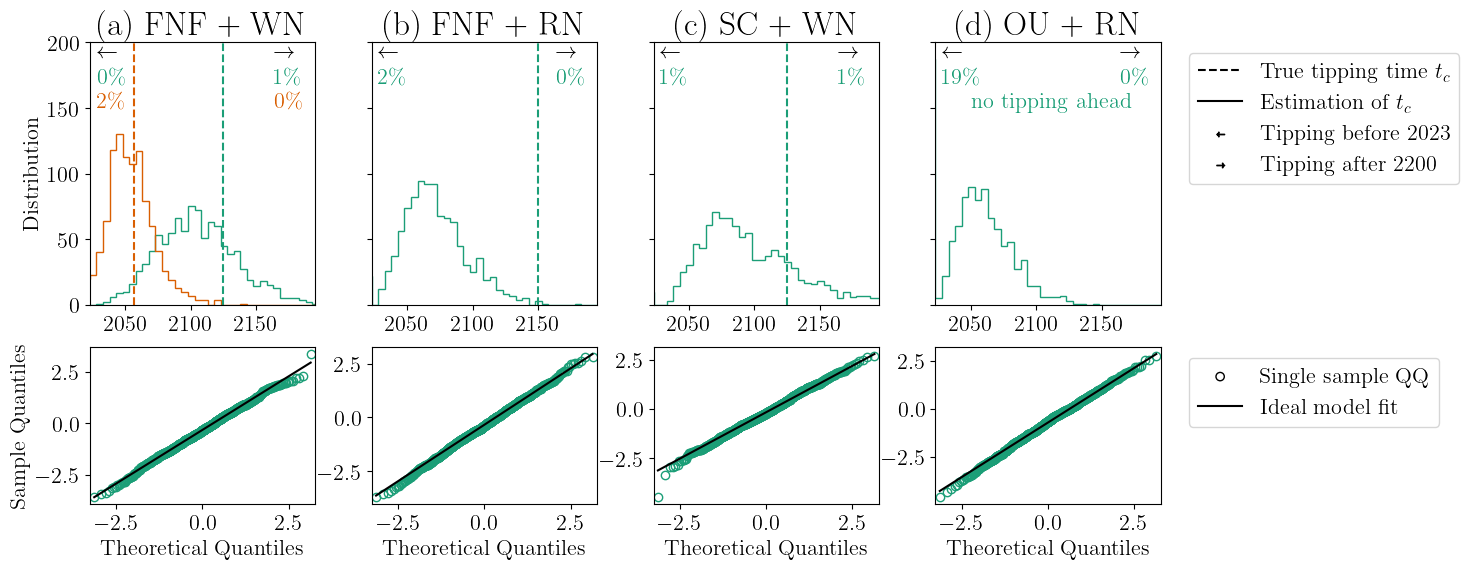

In [216]:
t_left = 2023
t_right = 2200
t_step = 5
model_subselection = [0,1,2,4]
modeldescrips = ["(a) FNF + WN","(b) FNF + RN","(c) SC + WN","(d) OU + RN"]
ncols = 5
fig, axs = plt.subplots(nrows=2,ncols=ncols,figsize=(16,6),gridspec_kw={'height_ratios': [1, 0.6], 'width_ratios': [1,1,1,1, 0.5]})
axs=axs.flatten()
bins = np.concatenate((np.array([0]),np.arange(t_left,t_right,t_step),np.array([1e20])))
for i in range(len(model_subselection)):
    t_c_values = np.array(pd.read_excel("EstimMatrix_"+modelnames[model_subselection[i]]+".xlsx").loc[:,"tc"])
    samplesize = len(t_c_values)
    hist = axs[i].hist(t_c_values,bins=bins,histtype="step",density=False)[0]
    #axs[i].set_xlabel("Tipping time $t_c$")
    axs[i].text(0.03,0.93,r"$\leftarrow$",color="black", transform=axs[i].transAxes)
    axs[i].text(0.03,0.84,str(round(hist[0]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], transform=axs[i].transAxes)
    axs[i].text(0.82,0.93,r"$\rightarrow$",color="black", transform=axs[i].transAxes)
    axs[i].text(0.82,0.84,str(round(hist[-1]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], transform=axs[i].transAxes)
    axs[i].set_xlim(t_left,t_right-t_step)
    axs[i].set_ylim(0,200)
    axs[i].set_title(modeldescrips[i])
    if i == 0: # Include estimation distribution on the intended model with tipping at 2057 (taken from DD23, but same result can be achieved using our model integration)
        t_c_values = np.array(pd.read_excel("EstimMatrix_1000repetitions.xlsx").loc[:,"tc"])
        samplesize = len(t_c_values)
        hist = axs[i].hist(t_c_values,bins=bins,histtype="step",density=False)[0]
        axs[i].axvline(2057,color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1],linestyle="dashed")
        axs[i].text(0.03,0.75,str(round(hist[0]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], transform=axs[i].transAxes)
        axs[i].text(0.82,0.75,str(round(hist[-1]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], transform=axs[i].transAxes)
    if model_subselection[i] in [0,1,2,5,6]:
        axs[i].axvline(t_0+tau_rs[modelnames[model_subselection[i]]],color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0],linestyle="dashed")
    else:
        axs[i].text(0.16,0.75,"no tipping ahead",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], transform=axs[i].transAxes)
    QQData = pd.read_csv("QQData_"+modelnames[model_subselection[i]]+".csv",index_col=0).values[:,0]
    statsmodels.graphics.gofplots.qqplot(QQData,ax=axs[i+ncols], markerfacecolor='none', markeredgecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    qqx = axs[i+ncols].lines[0].get_xdata()
    qqy = axs[i+ncols].lines[0].get_ydata()
    statsmodels.graphics.gofplots.qqline(ax=axs[i+ncols], line = "q", x = qqx, y = qqy, dist = scipy.stats.norm(),color="black")
    if not i == 0:
        axs[i+ncols].set_ylabel("")
        axs[i].set_yticklabels([])
axs[0].set_ylabel("Distribution")
axs[len(model_subselection)].plot([0,1],[0,1],color="black",linestyle="dashed")
axs[len(model_subselection)].plot([0,1],[0,1],color="black")
axs[len(model_subselection)].scatter([0],[0],marker=r"$\leftarrow$",c="black")
axs[len(model_subselection)].scatter([0],[0],marker=r"$\rightarrow$",c="black")
axs[len(model_subselection)].set_ylim(-1,-0.5)
axs[len(model_subselection)].legend(["True tipping time $t_c$","Estimation of $t_c$", "Tipping before "+str(t_left), "Tipping after "+str(t_right)],loc="upper left", bbox_to_anchor=(-0.35,1))
axs[len(model_subselection)].axis("off")
axs[len(model_subselection)+ncols].scatter([0],[0], facecolors='none', edgecolors="black")
axs[len(model_subselection)+ncols].plot([0,1],[0,1],c="black")
axs[len(model_subselection)+ncols].set_ylim(-1,-0.5)
axs[len(model_subselection)+ncols].legend(["Single sample QQ","Ideal model fit"],loc="upper left", bbox_to_anchor=(-0.35,1))
axs[len(model_subselection)+ncols].axis("off")

fig.subplots_adjust(hspace=0.2,wspace=0.28)
#plt.savefig("Plots/modelsubselection_QQ" + time.strftime("%Y%m%d-%H%M%S") + ".pdf",dpi=300,bbox_inches="tight")
plt.show()

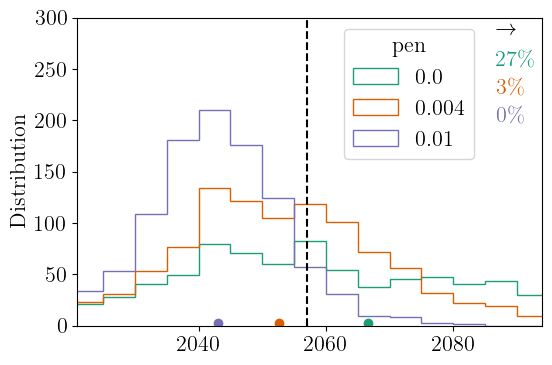

In [210]:
t_left = 2020
t_right = 2100
t_step = 5
true_t_c = 2057
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4))
bins = np.concatenate((np.array([0]),np.arange(t_left,t_right,t_step),np.array([1e20])))
estimmatrix = pd.read_excel("EstimMatrix_penalization.xlsx")
ax.text(0.9,0.93,r"$\rightarrow$",color="black", transform=ax.transAxes)
for i in range(estimmatrix["pen"].nunique()):
    pen = estimmatrix["pen"].unique()[i]
    t_c_values = estimmatrix.where(estimmatrix["pen"]==pen).loc[:,"tc"].dropna()
    samplesize = len(t_c_values)
    hist = ax.hist(t_c_values,bins=bins,histtype="step",density=False,color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i],linewidth=1)[0]
    ax.scatter([np.median(t_c_values)],[3],color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label='_nolegend_')
    ax.text(0.9,0.84-i*0.09,str(round(hist[-1]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], transform=ax.transAxes)
    ax.set_xlim(t_left+1,t_right-t_step-1)
    ax.set_ylim(0,300)
ax.legend(estimmatrix["pen"].unique(),title="pen", loc = "upper left", bbox_to_anchor=(0.55,1))
ax.axvline(true_t_c,color="black",linestyle="dashed")
ax.set_ylabel("Distribution")

#plt.savefig("Plots/penalization" + time.strftime("%Y%m%d-%H%M%S") + ".png",dpi=300,bbox_inches="tight")
plt.show()